In [16]:
import pandas as pd
# import modin.pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import confusion_matrix_pretty_print
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

from sklearn.metrics import confusion_matrix,classification_report,precision_score,\
auc, precision_recall_curve, roc_curve
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Dropout, MaxPooling2D
from keras import optimizers
from keras import metrics as kmetr
from tensorflow.keras.utils import plot_model

import pydot

In [7]:
#### test & train split
data = pd.read_csv('../saved F(Drug-Disease).csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075
0,D102100,DB00014,0,1.00000,0.44574,0.25000,0.52140,0.27515,0.05046,0.17621,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
1,D102100,DB00035,0,0.44574,1.00000,0.28249,0.63184,0.20779,0.05732,0.28302,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
2,D102100,DB00091,0,0.25000,0.28249,1.00000,0.33880,0.14734,0.15278,0.30108,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
3,D102100,DB00104,0,0.52140,0.63184,0.33880,1.00000,0.24138,0.06358,0.18717,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0
4,D102100,DB00115,0,0.27515,0.20779,0.14734,0.24138,1.00000,0.02730,0.09976,...,0.03072,0.14301,0.0,0.0,0.0,0.0,0.0,0.094405,0.12665,0.0


In [8]:
# data.iloc[:int(0.9*len(data.iloc[:,2])),:].to_csv('../trainSaved F(Drug-Disease).csv',index=False)
# data.iloc[int(0.9*len(data.iloc[:,2])):,:].to_csv('../testSaved F(Drug-Disease).csv',index=False)
                 
# del data

In [9]:
# dataTrain = pd.read_csv('../trainSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../testSaved F(Drug-Disease).csv')
# dataTest = pd.read_csv('../../triple_cosineSNF(zeros).csv')
# print(dataTest.shape,dataTrain.shape)

In [10]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, shuffle=True)

In [11]:
dataTrain = data.iloc[int(0.3*len(data.iloc[:,2])):,:]
dataTest = data.iloc[:int(0.3*len(data.iloc[:,2])),:]

In [12]:
X_train = dataTrain.values[:,3:]
y_train = dataTrain.values[:,2].astype(int)
trainNum = len(X_train)
del dataTrain

X_test = dataTest.values[:,3:]
y_test = dataTest.values[:,2].astype(int)
testNum = len(X_test)
del data

transformer = Normalizer().fit(X_train)  # fit does nothing.
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)


#reshape data to fit model
X_train = X_train.reshape(trainNum,16,67,1)
X_test = X_test.reshape(testNum,16,67,1)

# y_train = y_train + 1
# y_test  = y_test + 1
# y_train = y_train / 2
# y_test  = y_test / 2
# print(y_train[0:5], y_test[0:5])

#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# y_test[0]


In [28]:
# #create model
# model = Sequential()
# #add model layers
# model.add(Conv2D(128, kernel_size=4, activation='relu', input_shape=(16,71,1)))
# # model.add(Conv2D(64, kernel_size=2, activation='relu'))

# model.add(Conv2D(32, kernel_size=4, activation='relu'))
# # model.add(Conv2D(16, kernel_size=2, activation='relu'))
# model.add(Conv2D(8, kernel_size=4, activation='relu'))
# model.add(Flatten())
# # model.add(Dense( 64, activation='relu'))
# model.add(Dense( 32, activation='relu'))
# # model.add(Dropout(0.2))
# model.add(Dropout(0.4))
# # model.add(Dense( 16, activation='relu'))
# model.add(Dense( 8, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense( 2, activation='sigmoid'))
# # model.add(Softmax(128))
# model.summary()

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=4, activation='relu',\
                 input_shape=(16,67,1)))
# model.add(Conv2D(64, kernel_size=4, activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=4, activation='relu'))
model.add(Conv2D(16, kernel_size=4, activation='relu'))

model.add(Conv2D(8, kernel_size=4, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense( 32, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense( 16, activation='relu'))
model.add(Dense(2, activation='relu'))
# model.add(Softmax(128))
model.summary()


adam = tf.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
# model.compile(loss='hinge', optimizer=adam, metrics=[kmetr.categorical_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy',\
              metrics=['categorical_accuracy']) ## Minist

### Load the model's saved weights.
# model.load_weights('cnn_4_epoch.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 13, 64, 64)        1088      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 10, 61, 32)        32800     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 58, 16)         8208      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 55, 8)          2056      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 27, 8)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [29]:
# #### plotting model
# plot_model(model,show_shapes = True, to_file='model .png')

In [30]:
#### train the model

#compile model using accuracy to measure model performance
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)
class_weight = {0: 5,
                1: 95
               }


history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4, class_weight=class_weight)
# history = model.fit(X_train, y_train, epochs=1)


Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f50954bcf70>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x7f50954bcf70>. No

2021-08-03 11:13:27.596991: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 813935296 exceeds 10% of free system memory.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.step_function.<locals>.run_step at 0x7f50954bcc10>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.step_function.<locals>.run_ste

In [31]:
### Saveing the Model
model.save_weights('cnn_3_epoch.h5')


In [32]:
predit = model.predict(X_test)
#actual results for first 4 images in test set
print(predit[:4])


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f508a594ca0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: lineno is out of bounds
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7f508a594ca0>. Note

In [33]:
# #from sklearn.metrics import precision_recall_curve, roc_curve

prec, rec, thr = precision_recall_curve(y_test[:,1], predit[:,1])
aupr_val = auc(rec, prec)
fpr, tpr, thr = roc_curve(y_test[:,1], predit[:,1])
auc_val = auc(fpr, tpr)
print(aupr_val,auc_val)

0.5044253226797787 0.5


In [49]:
history.history

{'loss': [14.617297172546387,
  14.617294311523438,
  14.617290496826172,
  14.617294311523438],
 'categorical_accuracy': [0.9904539585113525,
  0.9904539585113525,
  0.9904539585113525,
  0.9904539585113525],
 'val_loss': [0.14265590906143188,
  0.14265590906143188,
  0.14265590906143188,
  0.14265590906143188],
 'val_categorical_accuracy': [0.991149365901947,
  0.991149365901947,
  0.991149365901947,
  0.991149365901947]}

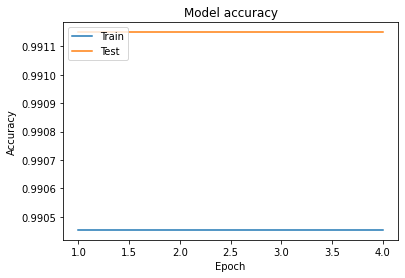

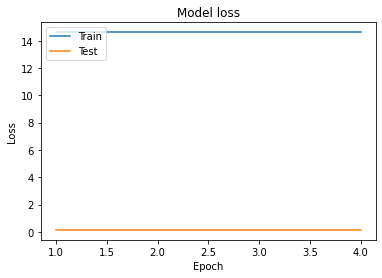

In [50]:

# Plot training & validation accuracy values
plt.plot(list(range(1,5)),history.history['categorical_accuracy'])
plt.plot(list(range(1,5)),history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(list(range(1,5)),history.history['loss'])
plt.plot(list(range(1,5)),history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [51]:
# # predit
# predit[:,0].shape 

In [52]:
predicts = []
for a,b in predit:
    if a >=b:
        predicts.append(0)
    else:
        predicts.append(1)
len(predicts)

81350

In [53]:
# predicts1 = []
# e = d = z = 0

# for a,b in predit:
#     if a >=0.90:
#         predicts1.append(0)
#         d += 1
#     elif b>=0.95:
#         predicts1.append(2)
#         e += 1
#     elif a<=0.05 and b<=0.1:
#         predicts1.append(1)
#         z += 1
# print('degrassive', d, 'enhancive', e, 'zeros', z)
# print("""
# Epoch04: degrassive 224 enhancive 2939 zeros 40
# Epoch05: degrassive 280 enhancive 2823 zeros 39
# Epoch06: degrassive 233 enhancive 2879 zeros 79
# Epoch07: degrassive 203 enhancive 2926 zeros 134
# Epoch08: degrassive 224 enhancive 2895 zeros 180
# Epoch09: degrassive 191 enhancive 2856 zeros 191
# Epoch10: degrassive 189 enhancive 2821 zeros 246
# Epoch11: degrassive 164 enhancive 2581 zeros 235
# Epoch12: degrassive 166 enhancive 2454 zeros 266
# """)

In [54]:
# max(list((dataTest.values[:,2]+1)/2))

[[80630   720]
 [    0     0]]


/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     80630
           1       0.00      0.00      0.00       720

    accuracy                           0.99     81350
   macro avg       0.50      0.50      0.50     81350
weighted avg       0.98      0.99      0.99     81350



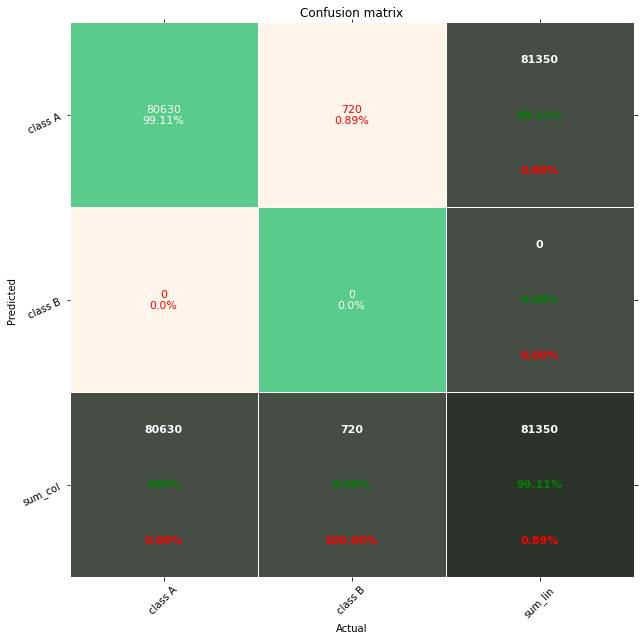

In [55]:

cm = confusion_matrix(list(predicts), list((dataTest.values[:,2])))
print(cm)

CR = classification_report(list((dataTest.values[:,2])),list(predicts))
print(CR)
# print(145/4702)
# i=0
# for j in list(data.values[9500:,2]+1):
#     if j==1:
#         i +=1
# print(i)

# plt.show()
plot_confusion_matrix_from_data(list((dataTest.values[:,2])), list(predicts))


In [56]:
print(pd.DataFrame(predit))

              0    1
0      0.240842  0.0
1      0.242847  0.0
2      0.238553  0.0
3      0.241568  0.0
4      0.234830  0.0
...         ...  ...
81345  0.232437  0.0
81346  0.237021  0.0
81347  0.238233  0.0
81348  0.241784  0.0
81349  0.244923  0.0

[81350 rows x 2 columns]


LinAlgError: singular matrix

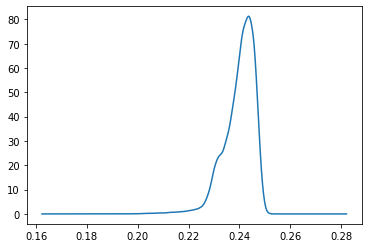

In [57]:
pd.DataFrame(predit).plot.density()


In [ ]:
pd.DataFrame(predit).iloc[:,0].plot.density()

In [ ]:
pd.DataFrame(predit).iloc[:,1].plot.density()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('Interaction drugs Probability')
plt.ylabel('frequency distribution')


In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('None Interaction drugs Probability')
plt.ylabel('frequency distribution')

In [ ]:

fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# matplotlib histogram
# plt.hist(pd.DataFrame(predit).iloc[:,1], color = 'blue', edgecolor = 'black',
#          bins = int(200))

# seaborn histogram
sns.distplot(pd.DataFrame(predit).iloc[:,1], hist=True, kde=False, 
             bins=int(100), color = 'blue',
             hist_kws={'edgecolor':'black'})

sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=False, 
             bins=int(100), color = 'red',
             hist_kws={'edgecolor':'black'})
# sns.distplot(pd.DataFrame(predit).iloc[:,0], hist=True, kde=True, 
#              bins=int(200), color = 'darkblue', 
#              hist_kws={'edgecolor':'black'},
#              kde_kws={'linewidth': 4})
# Add labels
plt.title('frequency Histogram of Drugs')
plt.xlabel('all drugs Probability')
plt.ylabel('frequency distribution')